In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import GPyOpt
import GPy
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler

import optuna

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LassoCV
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV, ElasticNetCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from catboost import CatBoost, CatBoostRegressor
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

In [3]:
filepath = './'

df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
original = pd.read_csv('./WildBlueberryPollinationSimulationData.csv', index_col=[0])

df_train['is_generated'] = 1
df_test['is_generated'] = 1
original['is_generated'] = 0

original = original.reset_index()
original['id'] = original['Row#'] + df_test.index[-1] + 1
original = original.drop(columns = ['Row#']).set_index('id')

target_col = 'yield'

print(f"df_train shape :{df_train.shape}")
print(f"df_test shape :{df_test.shape}")
print(f"original shape :{original.shape}")

df_train shape :(15289, 18)
df_test shape :(10194, 17)
original shape :(777, 18)


## EDA

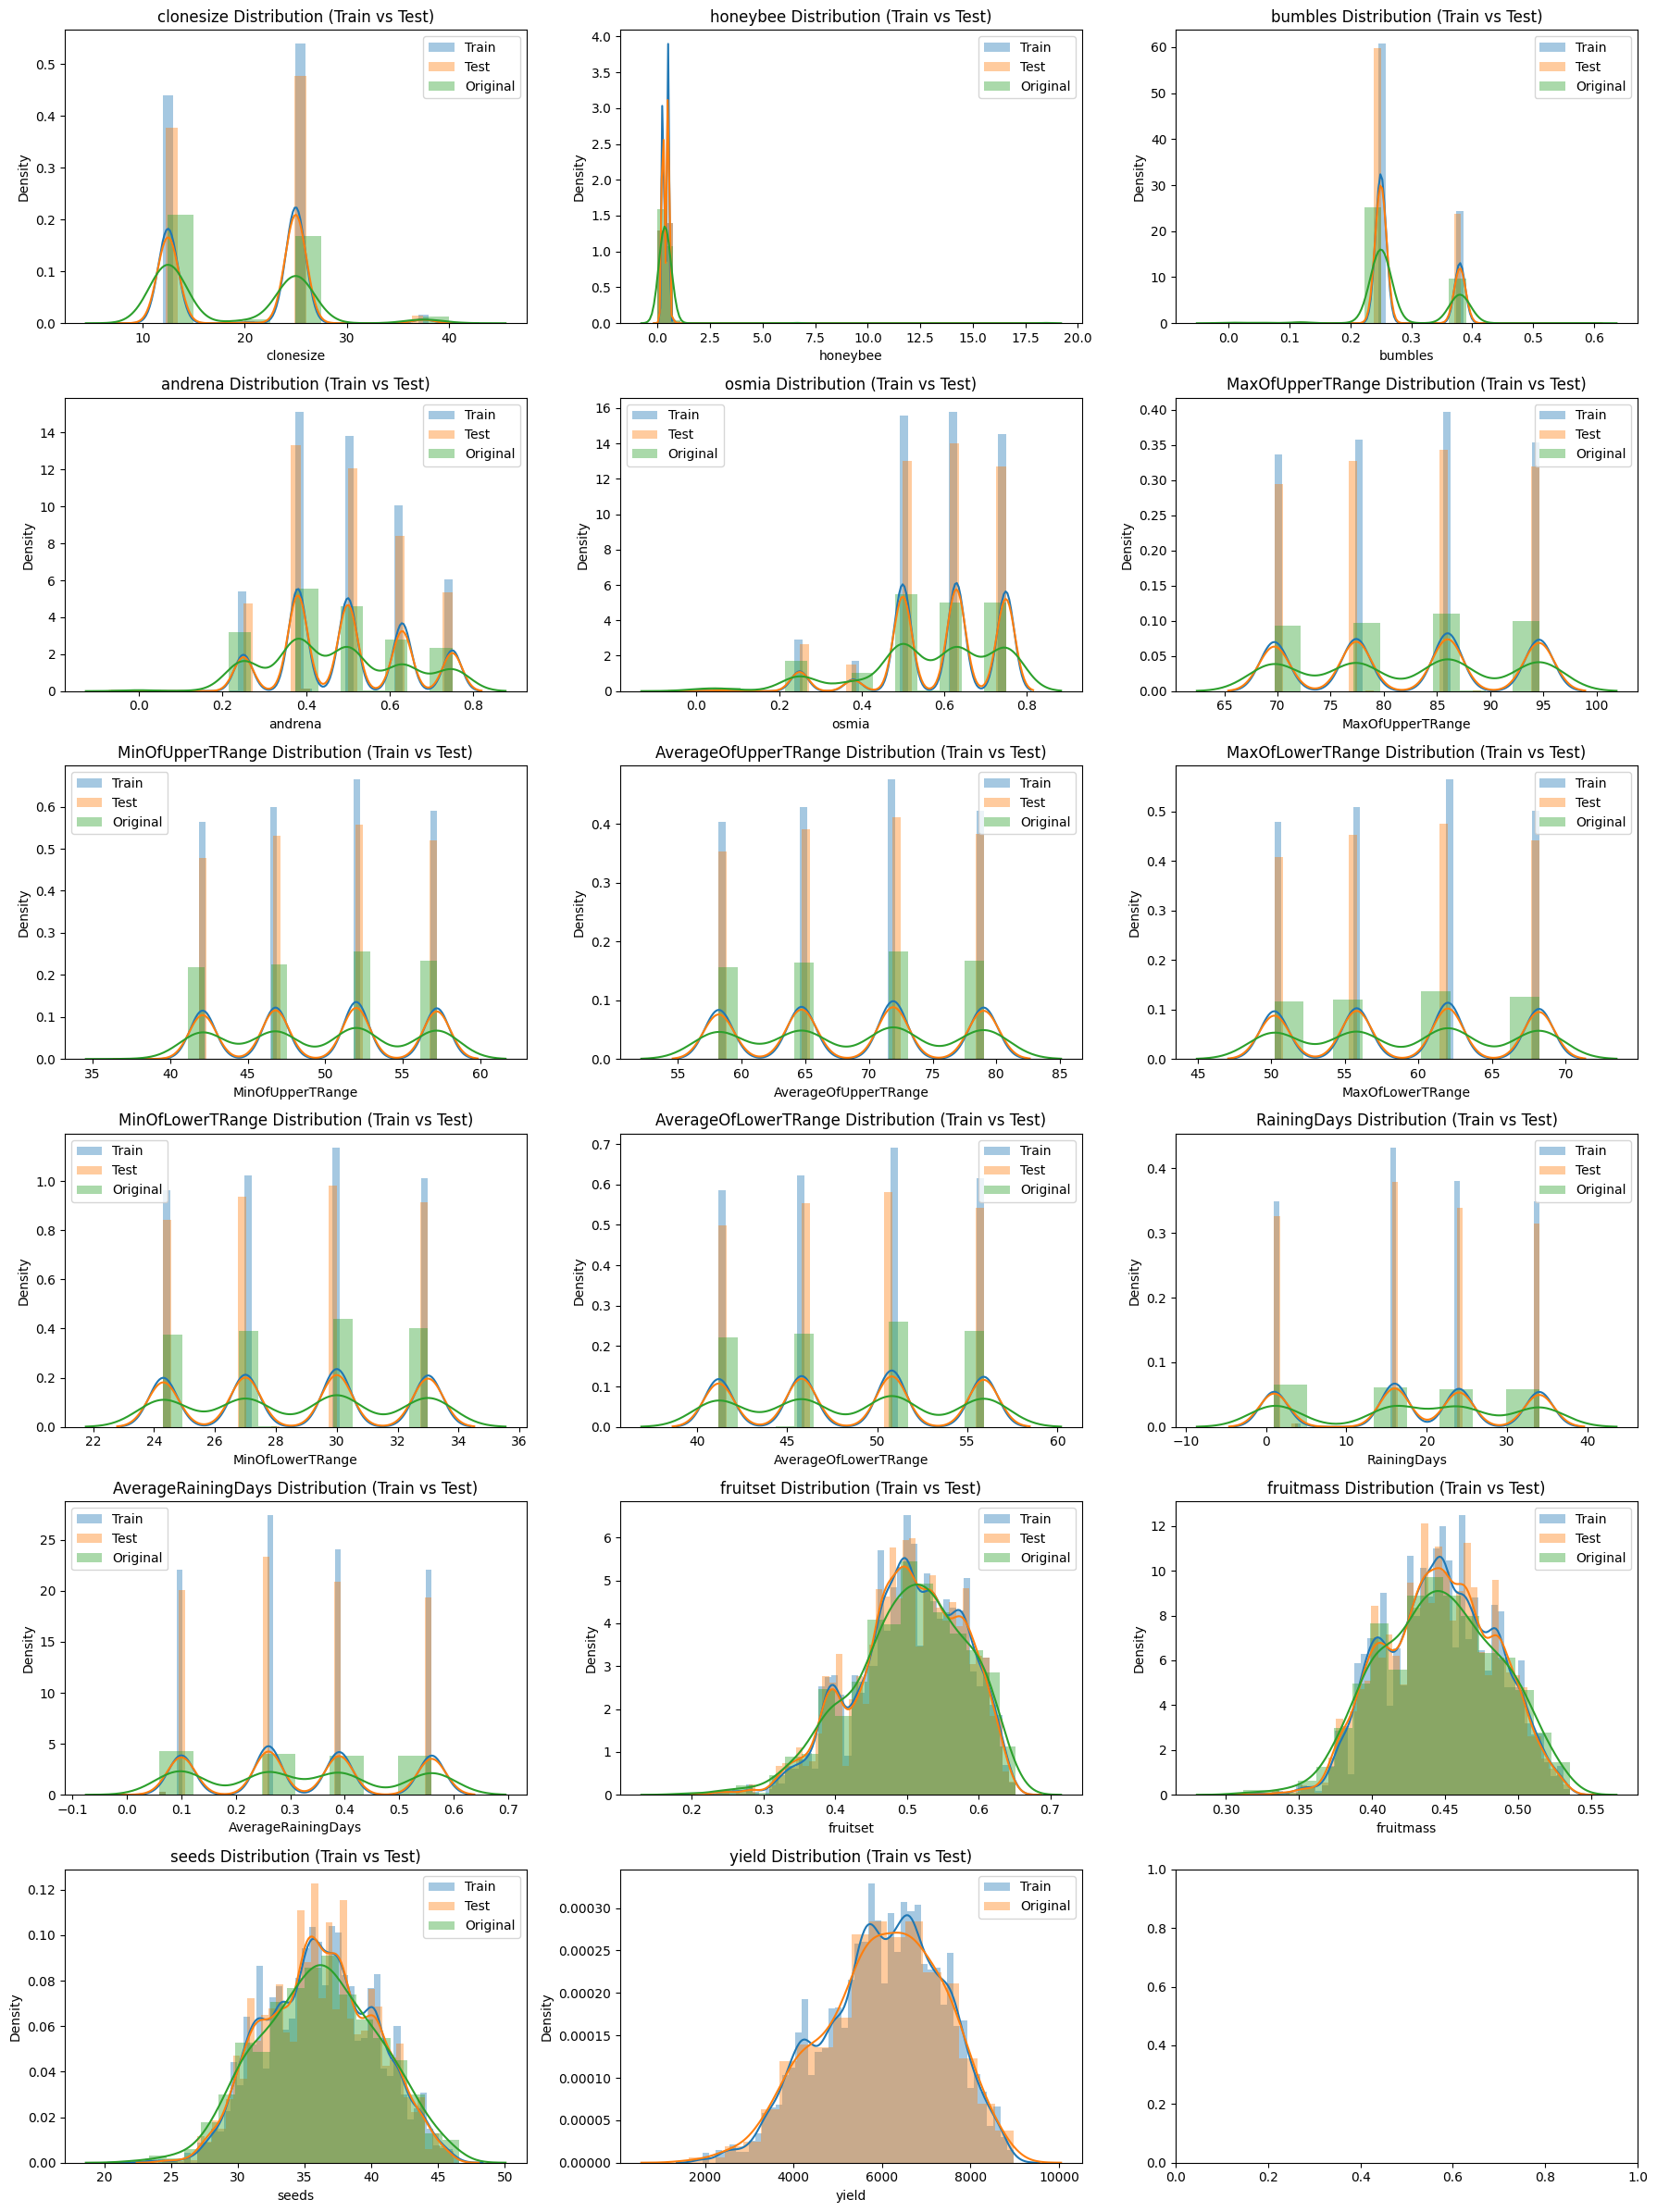

In [4]:
def plot_histograms(df_train, df_test, original, target_col, n_cols=3):
    n_cols = 3
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        if var_name != 'is_generated':
            ax = axes[i]
            sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
            if var_name != target_col:
                sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
            sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
            ax.set_title(f'{var_name} Distribution (Train vs Test)')
            ax.legend()

    plt.tight_layout()
    plt.show()
    
plot_histograms(df_train, df_test, original, target_col, n_cols=3)

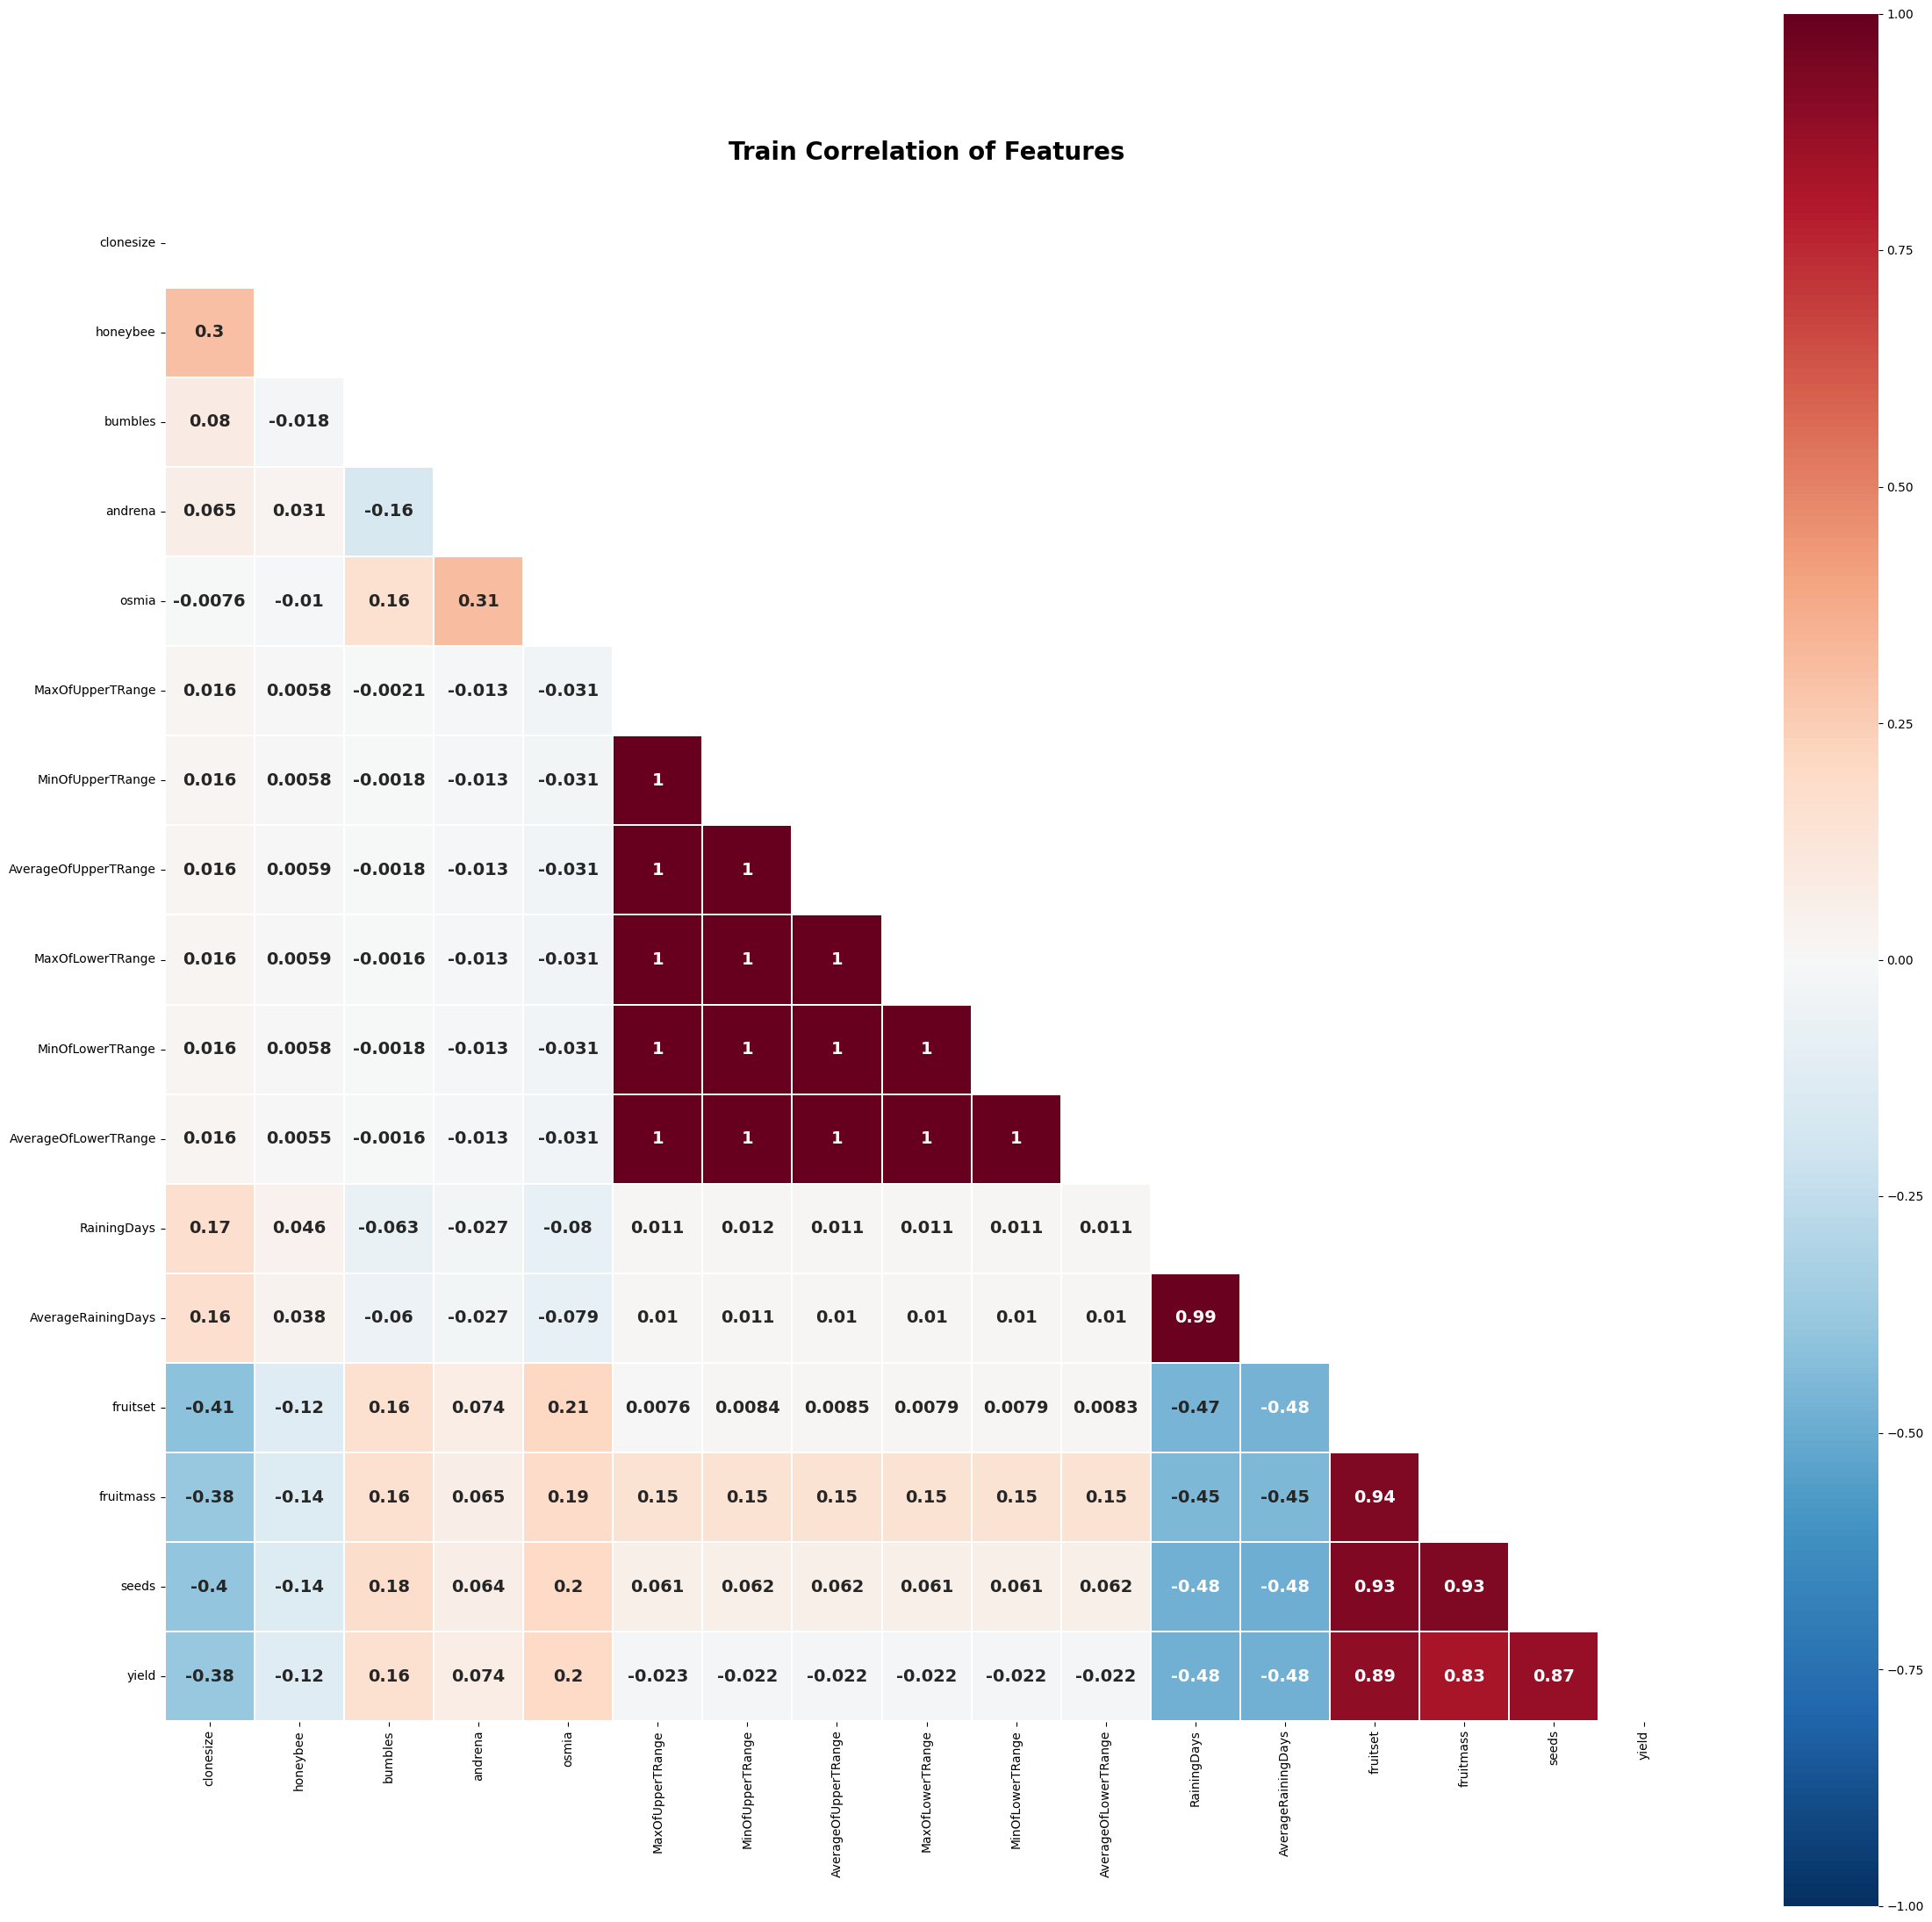

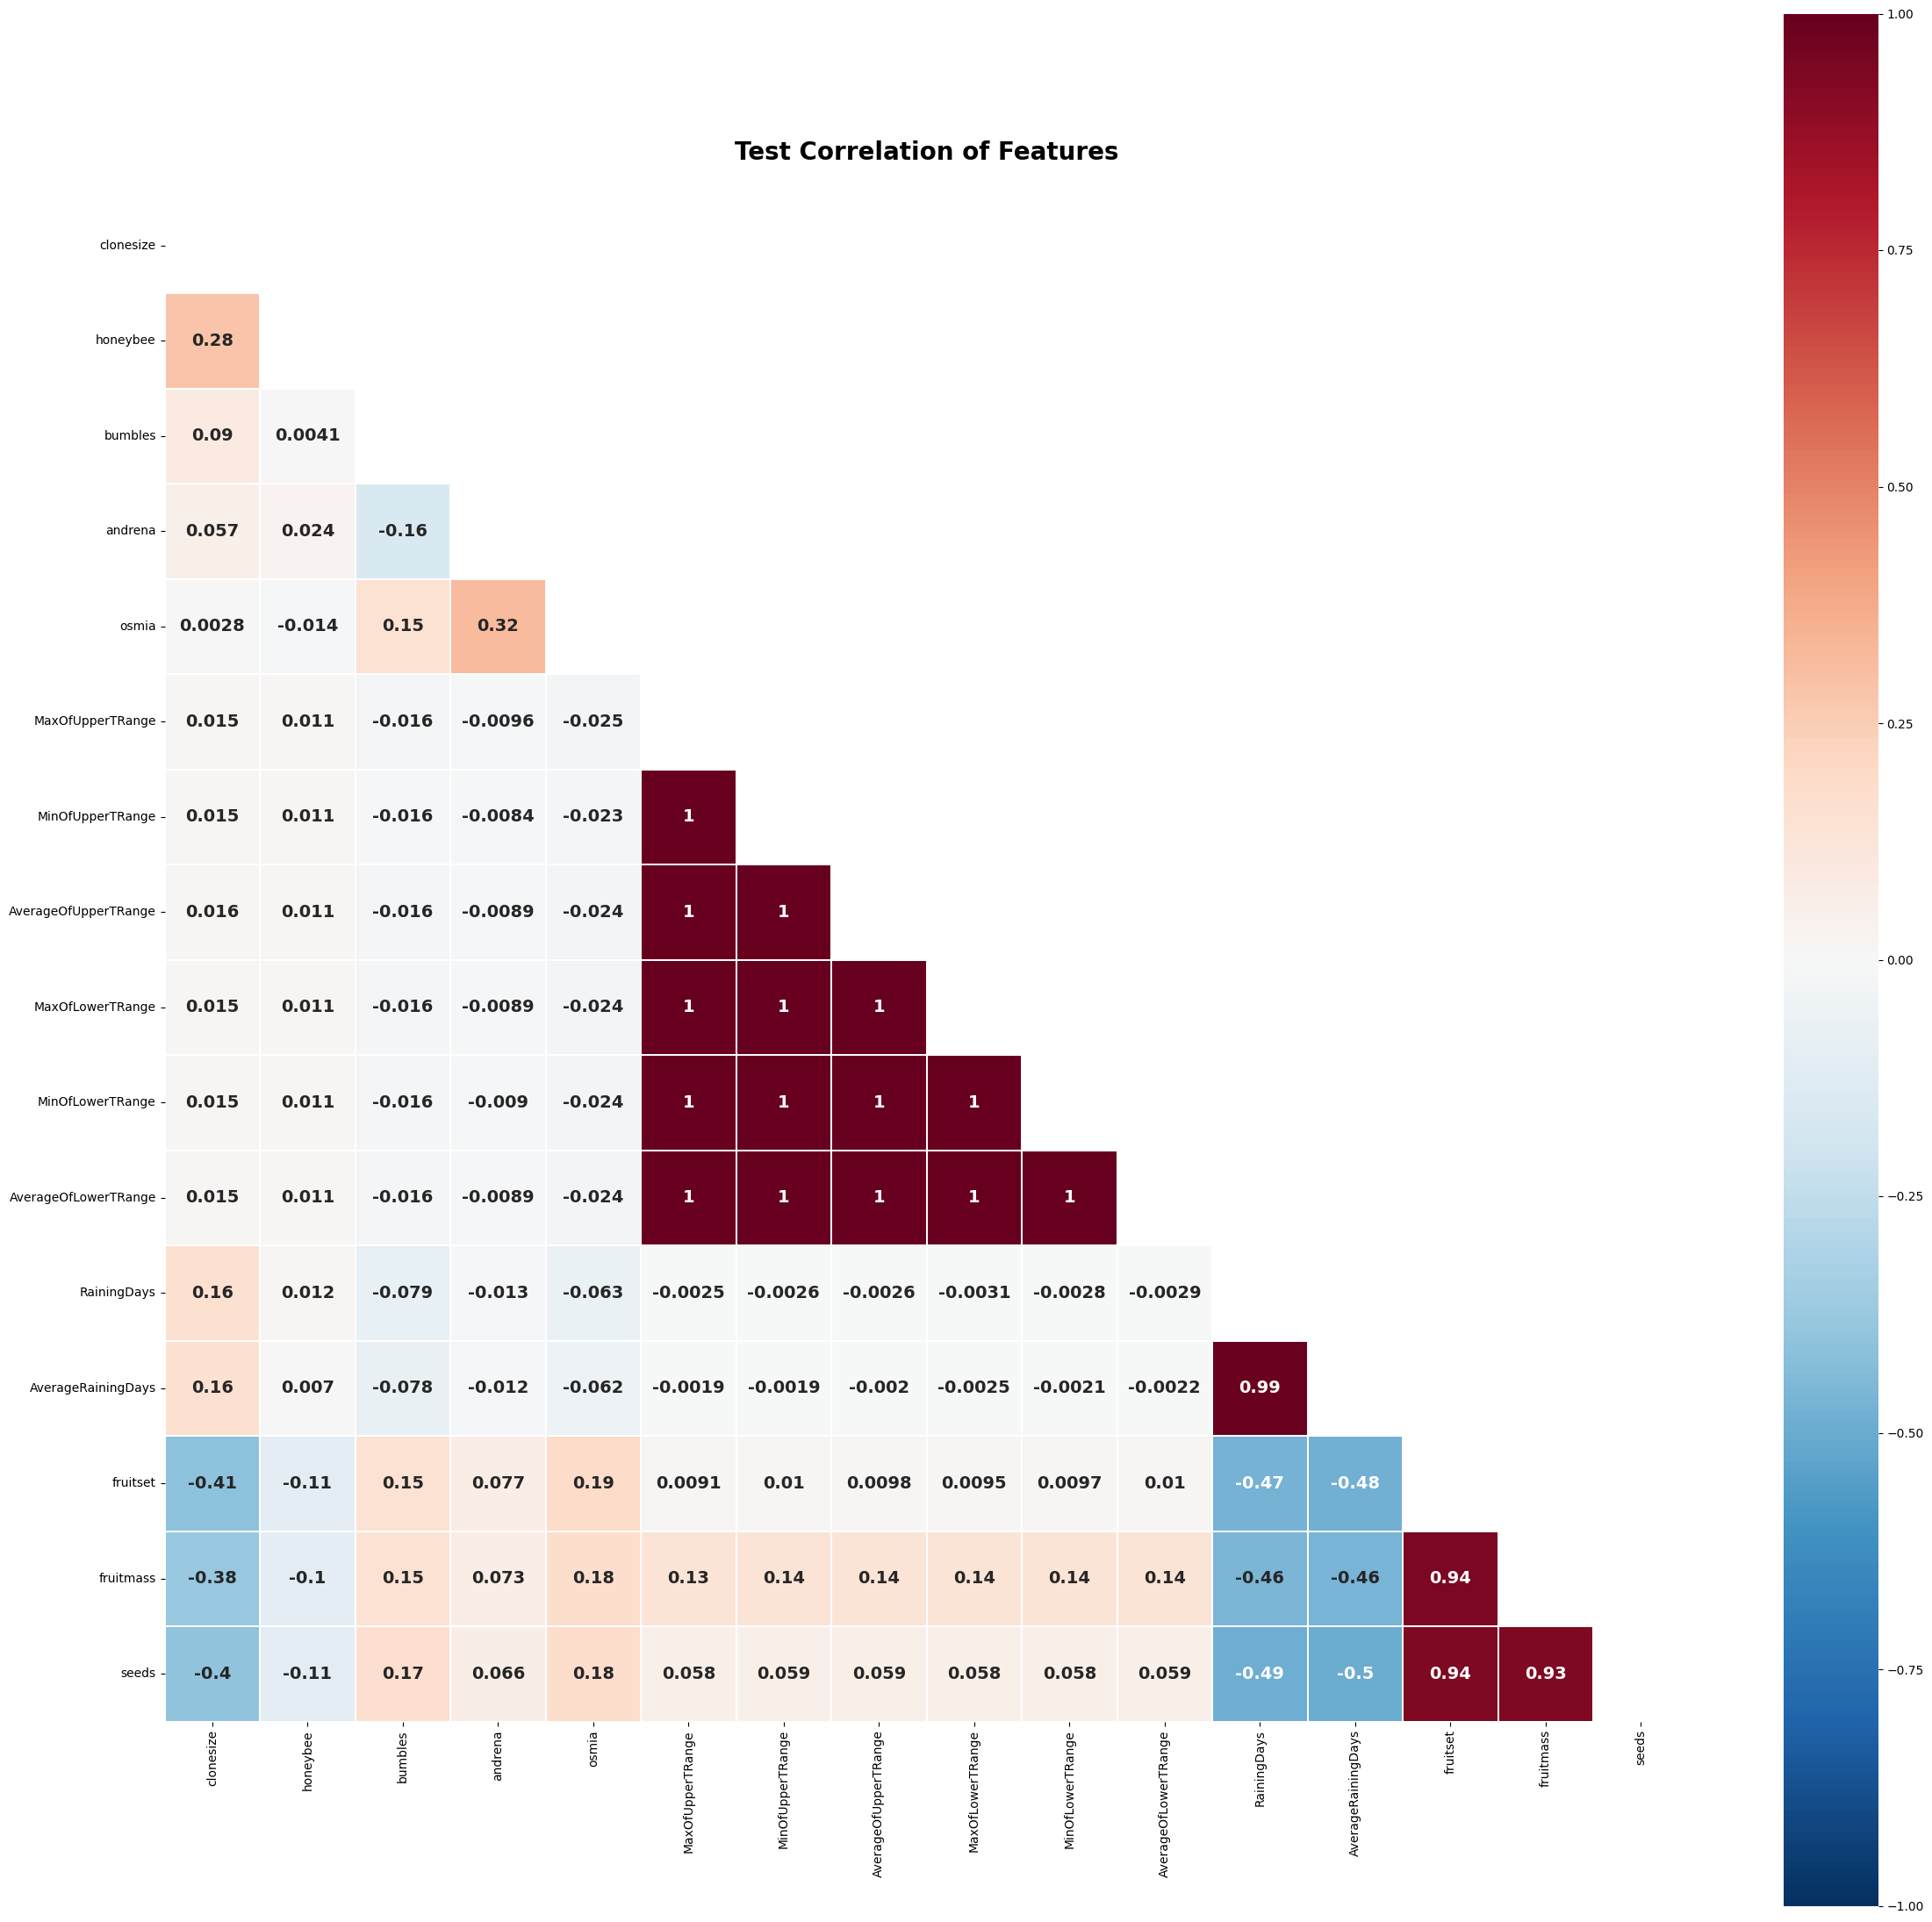

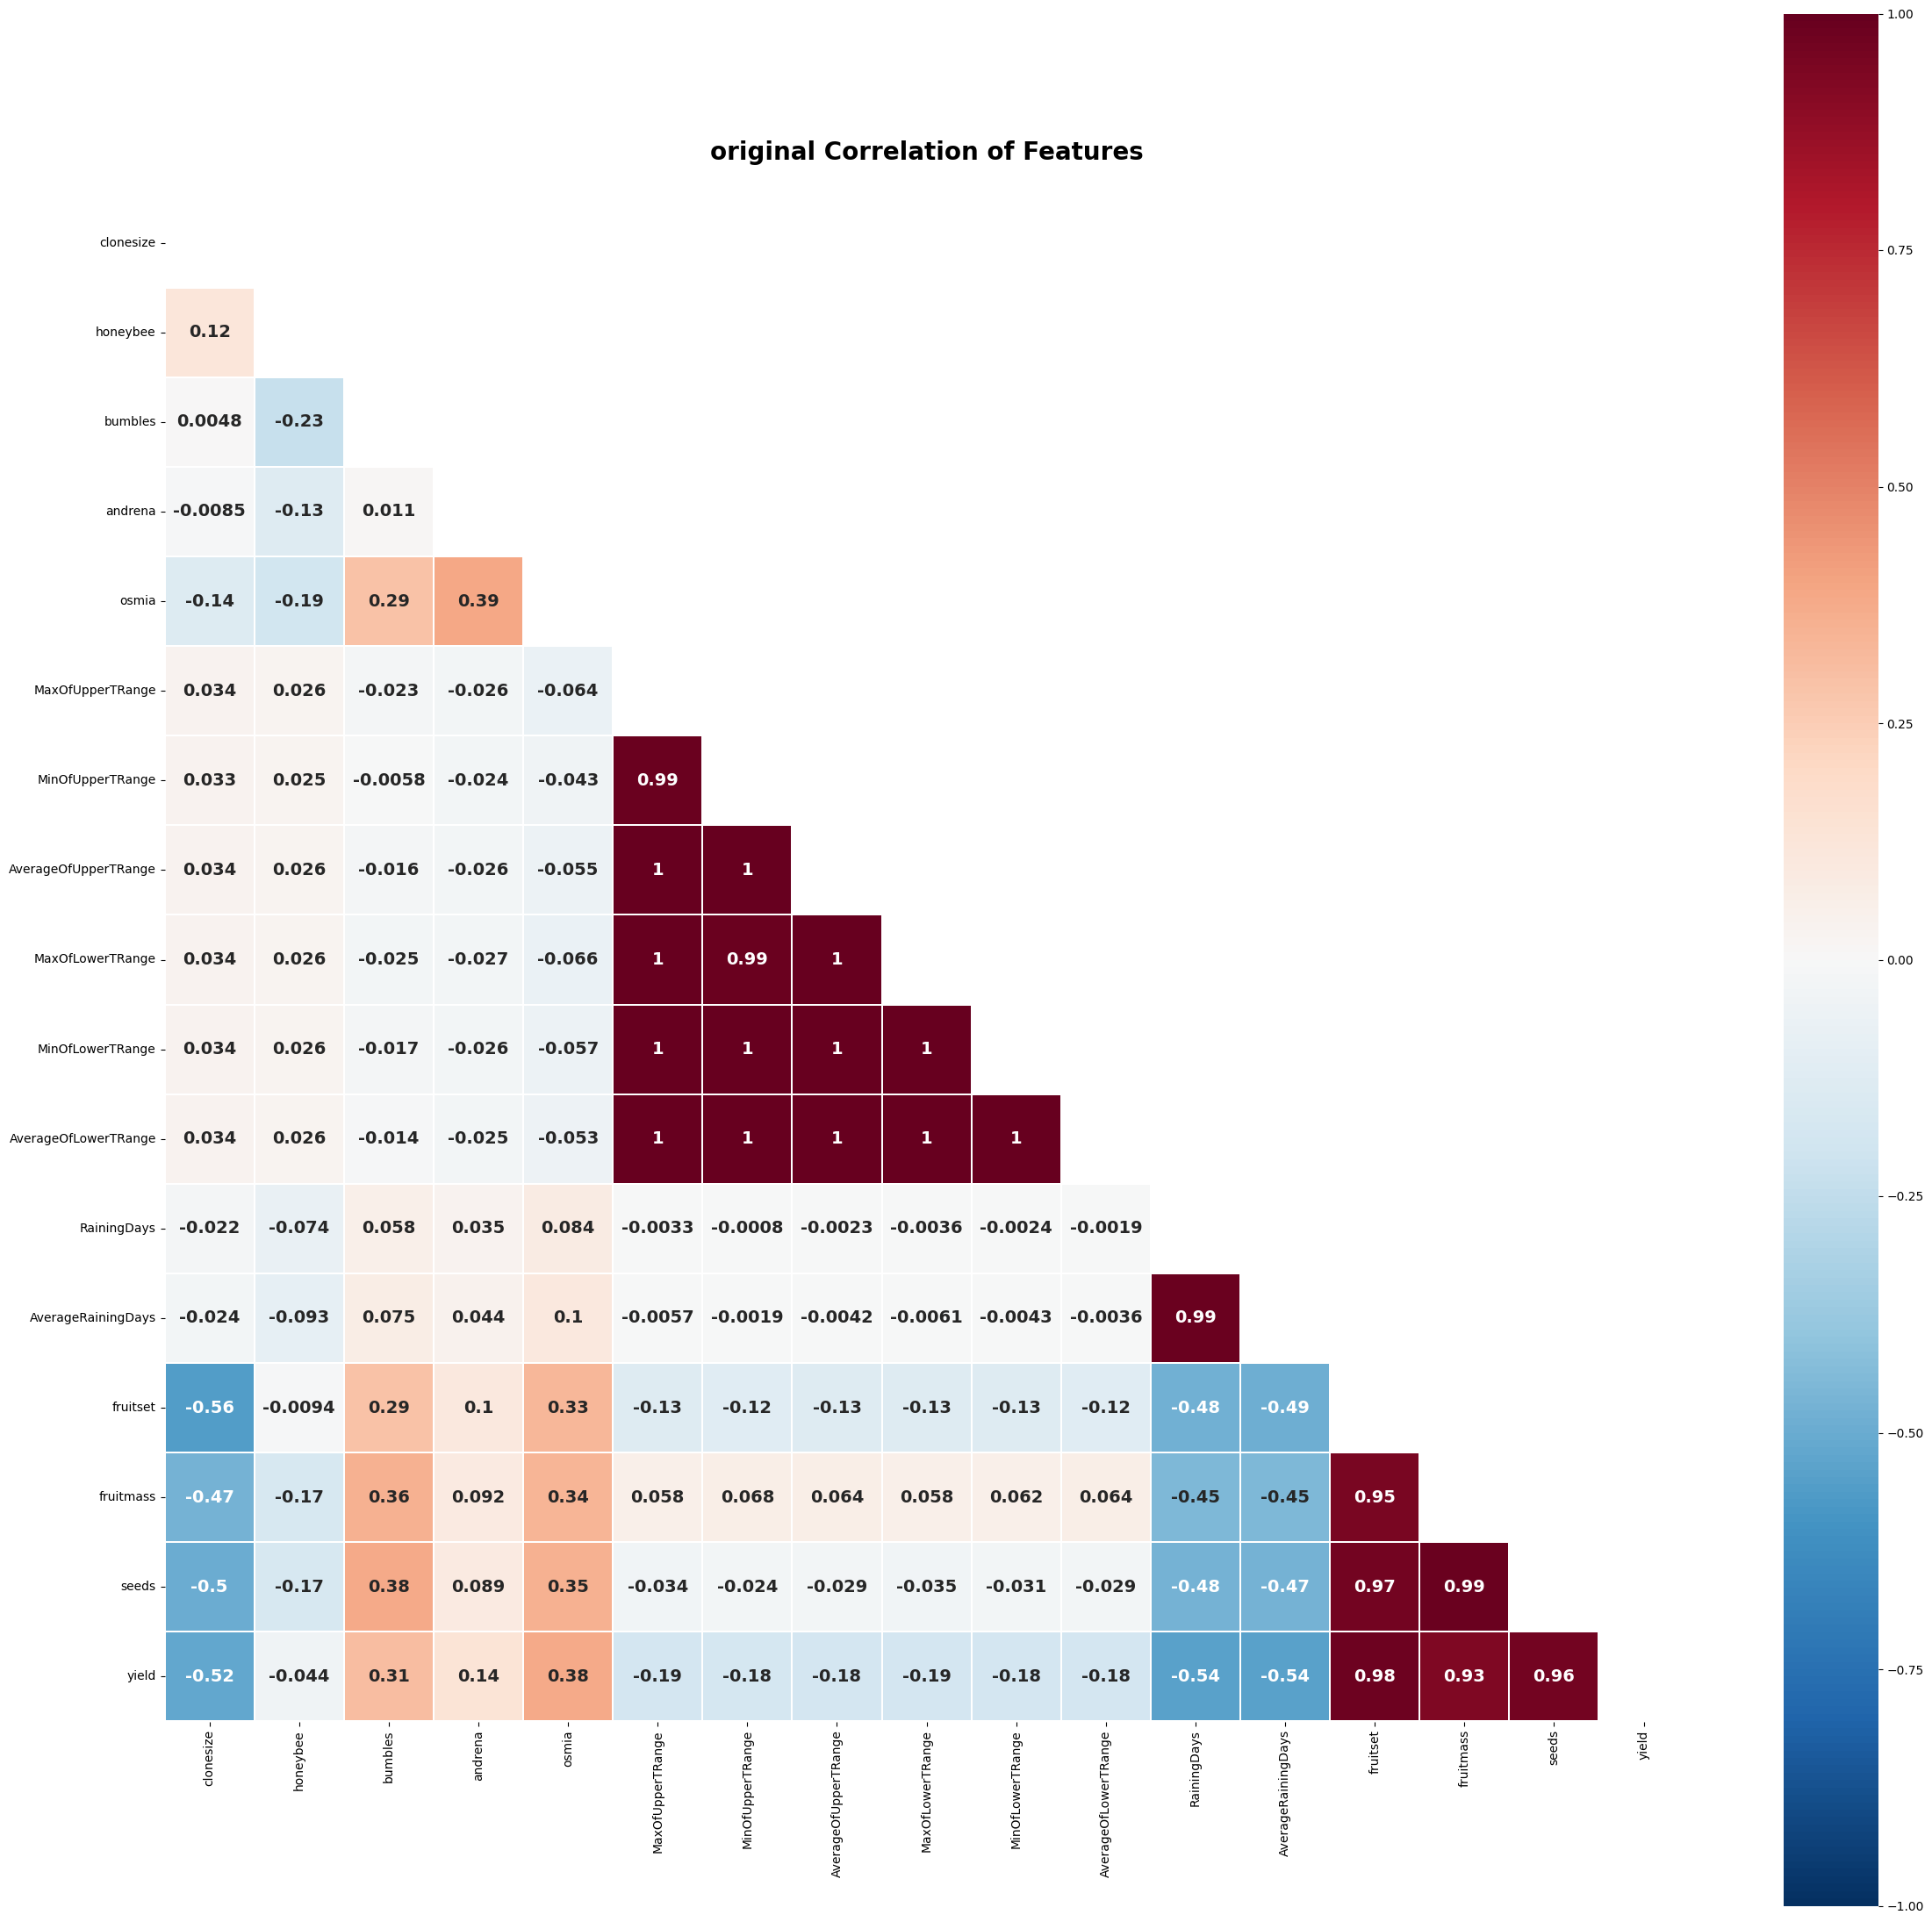

In [5]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(28, 28))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(df_train.drop('is_generated', axis=1), title='Train')
plot_heatmap(df_test.drop('is_generated', axis=1), title='Test')
plot_heatmap(original.drop('is_generated', axis=1), title='original')

## Prepare train and test sets

In [6]:
# Concatenate train and original dataframes, and prepare train and test sets
df_train = pd.concat([df_train, original])
X_train = df_train.drop([f'{target_col}'],axis=1).reset_index(drop=True)
y_train = df_train[f'{target_col}'].reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

# Drop_col
drop_cols = [
    'is_generated', 'fruitset', 'fruitmass', 'seeds'
]
X_train.drop(drop_cols, axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)

In [7]:
# StandardScaler
categorical_columns = ['is_generated']
numeric_columns = [_ for _ in X_train.columns if _ not in categorical_columns]
sc = StandardScaler() # MinMaxScaler or StandardScaler
X_train[numeric_columns] = sc.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = sc.transform(X_test[numeric_columns])

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

# Delete the train and test dataframes to free up memory
del df_train, df_test, original

X_train.head(5)

X_train shape :(16066, 13) , y_train shape :(16066,)
X_test shape :(10194, 13)


,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays
0,0.806994,0.264589,-0.60677,1.736566,-0.643680,-1.363628,-1.365172,-1.368497,-1.366203,-1.364887,-1.367088,0.458571,0.401957
1,0.806994,0.264589,-0.60677,0.056962,-0.643680,-1.363628,-1.365172,-1.368497,-1.366203,-1.364887,-1.367088,0.458571,0.401957
2,-1.081815,-0.340377,-0.60677,0.930356,0.276972,0.418096,0.419108,0.423982,0.418418,0.418670,0.413492,0.458571,0.401957
3,-1.081815,-0.340377,-0.60677,0.930356,-0.643680,-0.521955,-0.518090,-0.518051,-0.519264,-0.520044,-0.513894,0.458571,0.401957
4,0.806994,0.264589,-0.60677,0.930356,0.276972,-0.521955,-0.518090,-0.518051,-0.519264,-0.520044,-0.513894,0.458571,0.401957


In [8]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5):
        self.n_splits = n_splits
        self.kfold = kfold

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            raise ValueError(f"Invalid kfold: Must be True")
            
class Regressor:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)
        
    def _define_model(self):
        xgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 6,
            'learning_rate': 0.0116,
            'colsample_bytree': 1,
            'subsample': 0.6085,
            'min_child_weight': 9,
            'reg_lambda': 4.879e-07,
            'max_bin': 431,
            #'booster': 'dart',
            'n_jobs': -1,
            'eval_metric': 'mae',
            'objective': "reg:squarederror",
            #'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
        
        lgb_params = {
            'n_estimators': self.n_estimators,
            "num_leaves": 64,
            'min_child_samples': 20, 
            'learning_rate': 0.05,
            'subsample': 0.60,
            'colsample_bytree': 1,
            'reg_lambda': 5e-07,
            'objective': 'regression_l1',
            'metric': 'mean_absolute_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
                
        cb_params = {
            'n_estimators': self.n_estimators,
            'depth': 10,
            'learning_rate': 0.08,
            'l2_leaf_reg': 5e-05,
            'random_strength': 0.2,
            'max_bin': 400,
            'od_wait': 100,
            'grow_policy': 'Lossguide',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MAE',
            'loss_function': 'MAE',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
            'silent': True
        }
        
        models = {
            "xgb": xgb.XGBRegressor(**xgb_params),
            "lgb": lgb.LGBMRegressor(**lgb_params),
            "cat": CatBoostRegressor(**cb_params),
            "RandomForestRegressor": RandomForestRegressor(n_estimators=200, random_state=self.random_state, n_jobs=-1),
            "HistGradientBoostingRegressor": HistGradientBoostingRegressor(max_iter=self.n_estimators, learning_rate=0.01, loss="absolute_error", n_iter_no_change=300,random_state=self.random_state),
            "HuberRegressor": HuberRegressor(max_iter=3000),
            "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
        }
        
        return models

## Optimizer (--> Optimize MAE)

In [9]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=4000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-14, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the score for the weighted prediction
        score = mean_absolute_error(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

## Train Model

In [10]:
%%time

kfold = True
n_splits = 1 if not kfold else 5
random_state = 42
random_state_list = [42]
n_estimators = 9999
early_stopping_rounds = 800
verbose = False
device = 'cpu'

splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
regressor = Regressor(n_estimators, device, random_state)
test_predss = np.zeros((X_test.shape[0]))
oof_predss = np.zeros((X_train.shape[0]))
ensemble_score = []
weights = []
weights_list = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[], 'RandomForestRegressor':[], 'HistGradientBoostingRegressor':[], 'HuberRegressor':[], 'KNeighborsRegressor':[]}

score_dict = dict(zip(regressor.models_name, [[] for _ in range(regressor.len_models)]))

    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    
    n = i % n_splits
    m = i // n_splits
    # Get a set of Regressor models
    regressor = Regressor(n_estimators, device, random_state)
    models = regressor.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, y_train_)
        

        trained_models[f'{name}'].append(deepcopy(model))
        
        test_pred = model.predict(X_test).reshape(-1)
        y_val_pred = model.predict(X_val).reshape(-1)
        
        score = mean_absolute_error(y_val, y_val_pred)
        score_dict[name].append(score)
        print(f'{name} [FOLD-{n}] MAE score: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    
    score = mean_absolute_error(y_val, y_val_pred)
    print(f'Ensemble [FOLD-{n} SEED] MAE score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    weights_list.append(optweights)
    
    # Predict to X_test by the best ensemble weights
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    oof_predss[X_val.index] = optweights.predict(oof_preds)
    
    gc.collect()

xgb [FOLD-0] MAE score: 774.37358
lgb [FOLD-0] MAE score: 764.62603
cat [FOLD-0] MAE score: 764.42443
RandomForestRegressor [FOLD-0] MAE score: 796.32455
HistGradientBoostingRegressor [FOLD-0] MAE score: 765.17116
HuberRegressor [FOLD-0] MAE score: 782.99574
KNeighborsRegressor [FOLD-0] MAE score: 844.17364
Ensemble [FOLD-0 SEED] MAE score 763.51252
xgb [FOLD-1] MAE score: 803.55075
lgb [FOLD-1] MAE score: 804.23434
cat [FOLD-1] MAE score: 797.23917
RandomForestRegressor [FOLD-1] MAE score: 829.19952
HistGradientBoostingRegressor [FOLD-1] MAE score: 804.31545
HuberRegressor [FOLD-1] MAE score: 820.50138
KNeighborsRegressor [FOLD-1] MAE score: 897.88175
Ensemble [FOLD-1 SEED] MAE score 796.52008
xgb [FOLD-2] MAE score: 792.06220
lgb [FOLD-2] MAE score: 782.45489
cat [FOLD-2] MAE score: 779.70636
RandomForestRegressor [FOLD-2] MAE score: 814.04498
HistGradientBoostingRegressor [FOLD-2] MAE score: 782.62245
HuberRegressor [FOLD-2] MAE score: 800.18515
KNeighborsRegressor [FOLD-2] MAE scor

## Scores for each model

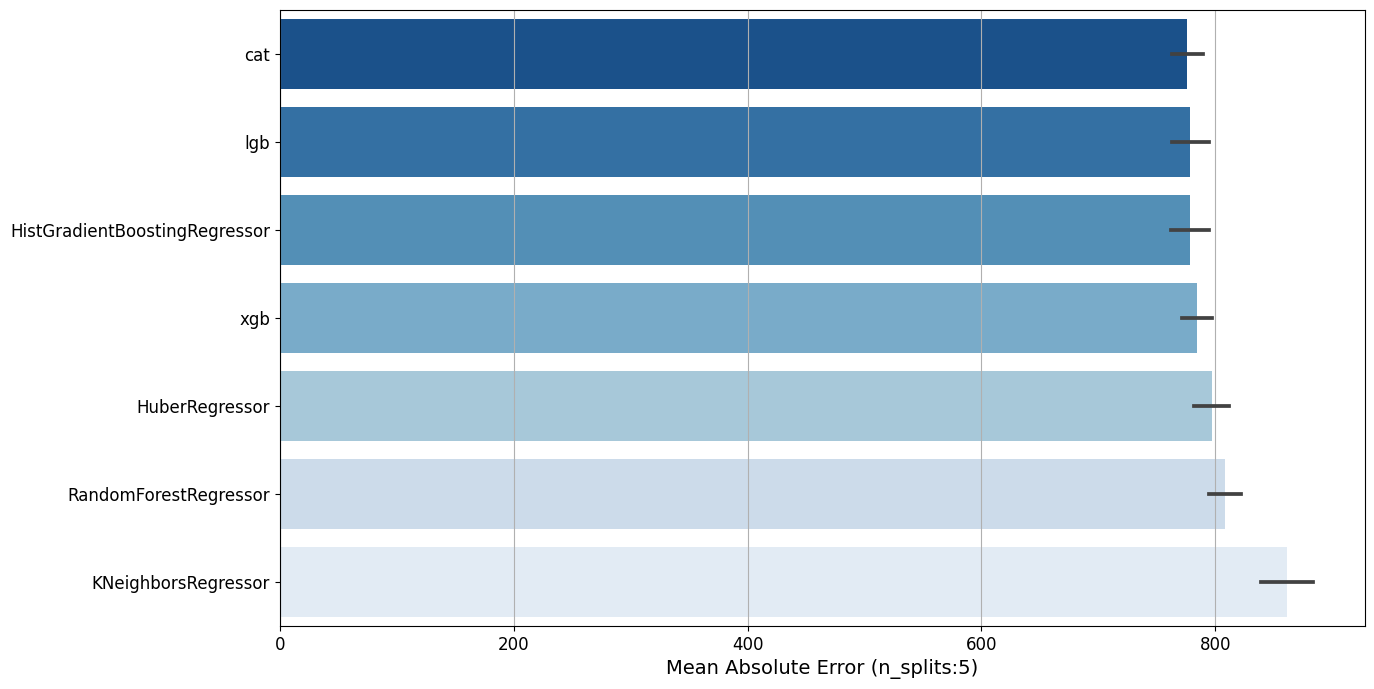

In [11]:
def plot_score_from_dict(score_dict, title='Mean Absolute Error', ascending=True):
    score_df = pd.melt(pd.DataFrame(score_dict))
    score_df = score_df.sort_values('value', ascending=ascending)
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='value', y='variable', data=score_df, palette='Blues_r', errorbar='sd')
    plt.xlabel(f'{title}', fontsize=14)
    plt.ylabel('')
    #plt.title(f'{title}', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='x')
    plt.show()
    
plot_score_from_dict(score_dict, title=f'Mean Absolute Error (n_splits:{n_splits})')

## Weight of the Ensemble

Ensemble MAE score 775.11339 ± 12.03388

--- Model Weights ---
xgb: 0.02644 ± 0.05258
lgb: 0.18366 ± 0.19854
cat: 0.88371 ± 0.08491
RandomForestRegressor: 0.00015 ± 0.00016
HistGradientBoostingRegressor: 0.35044 ± 0.33991
HuberRegressor: 0.08166 ± 0.03819
KNeighborsRegressor: 0.00602 ± 0.01058


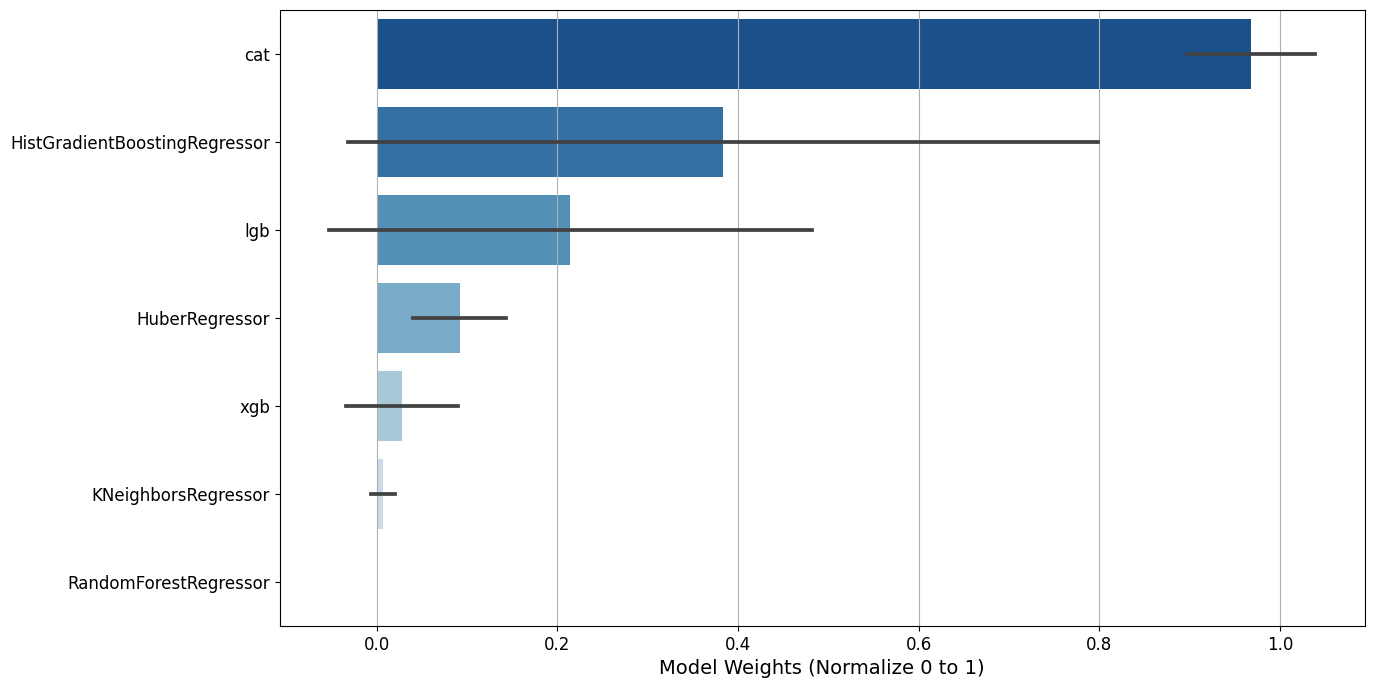

In [12]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble MAE score {mean_score:.5f} ± {std_score:.5f}')

print('')
# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')
    
# weight_dict = dict(zip(list(score_dict.keys()), np.array(weights).T.tolist()))
# plot_score_from_dict(weight_dict, title='Model Weights', ascending=False)
normalize = [((weight - np.min(weight)) / (np.max(weight) - np.min(weight))).tolist() for weight in weights]
weight_dict = dict(zip(list(score_dict.keys()), np.array(normalize).T.tolist()))
plot_score_from_dict(weight_dict, title='Model Weights (Normalize 0 to 1)', ascending=False)

## Make Submission

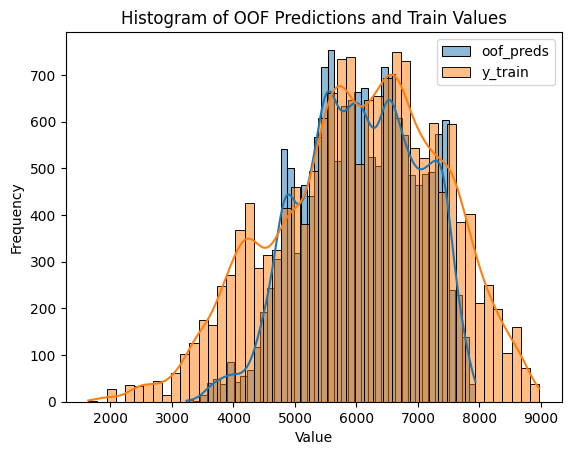

In [13]:
# plt.figure(figsize=(20, 6))
# plt.subplot(1, 2, 1)
sns.histplot(oof_predss, kde=True, alpha=0.5, label='oof_preds')
sns.histplot(y_train.values, kde=True, alpha=0.5, label='y_train')
plt.title('Histogram of OOF Predictions and Train Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

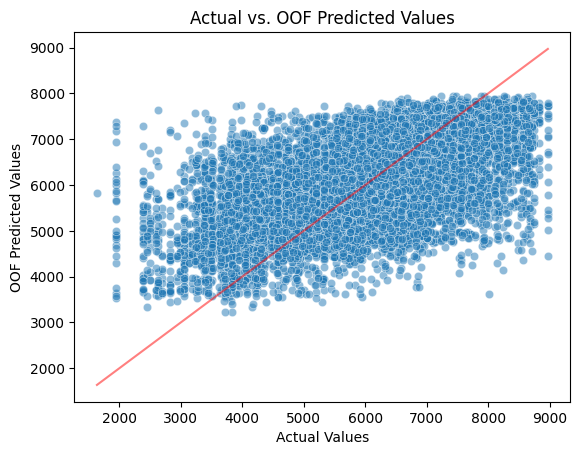

In [14]:
# plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train.values, y=oof_predss, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('OOF Predicted Values')
plt.title('Actual vs. OOF Predicted Values')

plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', alpha=0.5)
plt.show()

# Optimization

In [16]:
class blueberry():
    def __init__(self,bounds=None):
        self.input_dim = 5
        if bounds is  None: self.bounds = [(5,50),(0,1),(0,1),(0,1),(0,1)]
        else: self.bounds = bounds
        self.fmin = 0
        self.name = 'Sum of Powers'
        self.min = [(0.)*5]
    def f(self, x):
        x = x.reshape(-1,5)
        n = x.shape[0]
        if x.shape[1] != 5:
            return 'wrong input dimension'

        new_row = np.array([86, 52, 71.9, 62, 30, 50.8, 16, 0.26])
        x = np.hstack((x, np.broadcast_to(new_row, (n, 8))))
        print(x)
        test_predss = np.zeros((x.shape[0]))
        print(test_predss)
        for i in range(5):
            test_preds = []
            for name, _ in trained_models.items():
                model = trained_models[f'{name}'][i]
                test_pred = model.predict(x).reshape(-1)
                test_preds.append(test_pred)
            optweights = weights_list[i]
            test_predss += optweights.predict(test_preds) / 5
        noise = np.random.normal(0, 1000, n).reshape(n, 1)
        return -test_predss.reshape(n,1) + noise

In [17]:
f_noise = blueberry()
bounds =[{'name': 'clonesize', 'type': 'continuous', 'domain': (5,50)},
         {'name': 'honeybee', 'type': 'continuous', 'domain': (0.1,0.8)},
         {'name': 'bumbles', 'type': 'continuous', 'domain': (0.1,0.8)},
         {'name': 'andrena', 'type': 'continuous', 'domain': (0.1,0.8)},
         {'name': 'osmia', 'type': 'continuous', 'domain': (0.1,0.8)}]

In [18]:
blueberry_max = GPyOpt.methods.BayesianOptimization(f_noise.f,
                                              domain=bounds,
                                              model_type = 'GP',
                                              acquisition_type='MPI',
                                              verbosity=True)

[[32.59171021  0.52527172  0.40324003  0.54778471  0.49034165 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]
[[18.27293813  0.29609832  0.36591178  0.13756434  0.63668904 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]
[[36.53285852  0.17526605  0.78661714  0.75450105  0.19978492 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]
[[ 5.48266688  0.58869775  0.17358159  0.51678056  0.39462328 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]
[[ 9.89373736  0.5679731   0.66750293  0.18655159  0.44842078 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]


In [19]:
# runs the optimization for the three methods
max_iter = 100
max_time = 1000

blueberry_max.run_optimization(max_iter, max_time, verbosity=True, eps=1e-10)

[[ 9.92348554  0.56805218  0.66583071  0.17042424  0.44588992 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]
num acquisition: 1, time elapsed: 2.01s
[[10.08697567  0.43571684  0.47411381  0.23448056  0.43919552 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]
num acquisition: 2, time elapsed: 2.67s
[[47.67353595  0.30656804  0.74736105  0.10059397  0.46194663 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]
num acquisition: 3, time elapsed: 3.28s
[[30.98814889  0.64083799  0.65828311  0.51810019  0.69451138 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]
num acquisition: 4, time elapsed: 3.85s
[[31.93216452  0.5211984   0.54033503  0.56356496  0.54695206 86.
  52.         71.9        62.         30.         50.8        16.
   0.26      ]]
[0.]
num acquisition: 5, time elapsed: 4.46s
[[32.00776478  0.51748845  0.450472

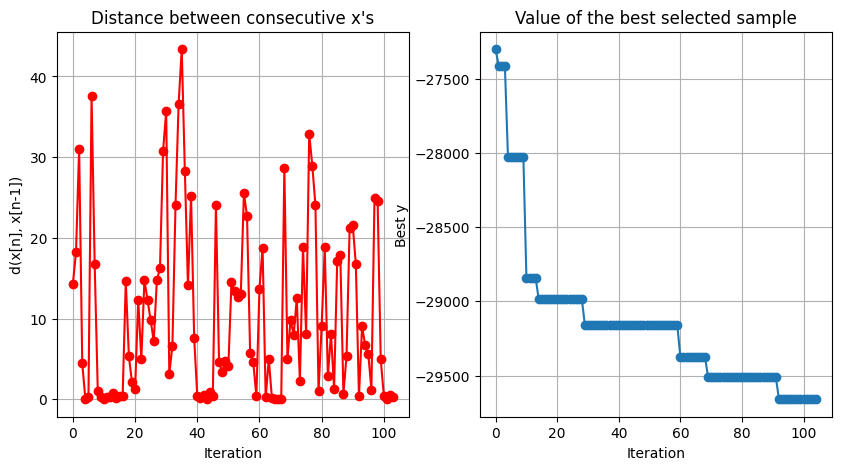

<Figure size 640x480 with 0 Axes>

In [20]:
blueberry_max.plot_convergence()
plt.savefig('convergence.png')

In [21]:
blueberry_max.x_opt

array([6.4385878 , 0.35176762, 0.3477644 , 0.52918607, 0.69359318])

In [22]:
blueberry_max.fx_opt

-29659.099315667794